In [117]:
# python=3.8
# conda env name : gender_pred_env

# Packges

In [118]:
# python=3.8
# conda env name: gender_pred_env
# Packages
import joblib
import numpy as np
import pandas as pd
import warnings
import xgboost as xgb
import mlflow
import optuna
from optuna.integration import XGBoostPruningCallback
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,precision_score, recall_score, roc_curve, auc, log_loss
import seaborn as sns
from sklearn.metrics import log_loss

warnings.filterwarnings('ignore')

In [119]:
# Load Data
df = pd.read_pickle('data/dataset_after_preporcessing.pkl')
df.head()

,name,sex,name_length,last_letter,first_letter
0,ابتسام,0,6,م,ا
1,ابتهاج,0,6,ج,ا
2,ابتهال,0,6,ل,ا
3,اجتهاد,0,6,د,ا
4,ازدهار,0,6,ر,ا


In [120]:
max_name_length = max(df['name'].apply(len))
unique_chars = set(''.join(df['name']))  
vocab_size = len(unique_chars) + 1  

# Tokenizing and padding the 'name' column for LSTM input
tokenizer = Tokenizer(num_words=vocab_size, char_level=True)  # char_level=True for character tokenization
tokenizer.fit_on_texts(df['name'])
sequences = tokenizer.texts_to_sequences(df['name'])
padded_sequences = pad_sequences(sequences, maxlen=max_name_length)

In [121]:
first_letter = df['name'].apply(lambda x: x[0])
last_letter = df['name'].apply(lambda x: x[-1])

first_letter_encoded = np.array([ord(char) for char in first_letter])
last_letter_encoded = np.array([ord(char) for char in last_letter])

max_unicode_value_first = np.max(first_letter_encoded)
max_unicode_value_last = np.max(last_letter_encoded)
max_unicode_value = max(max_unicode_value_first, max_unicode_value_last)

In [122]:
# Load the scaler models
scaler_first = joblib.load('saved_models/scaler_models/scaler_first_letter.pkl')
scaler_last = joblib.load('saved_models/scaler_models/scaler_last_letter.pkl')

# Transform the new data using the loaded scalers
first_letter_encoded_scaled = scaler_first.transform(first_letter_encoded.reshape(-1, 1))
last_letter_encoded_scaled = scaler_last.transform(last_letter_encoded.reshape(-1, 1))

In [123]:
y = df['sex'].values
name_length = df['name_length'].values
X = list(zip(padded_sequences, first_letter_encoded_scaled, last_letter_encoded_scaled, name_length))

# Define the size for the test and validation sets as percentages
test_size_percentage = 0.1
validation_size_percentage = 0.1

# Calculate the actual sizes for the test and validation sets
total_size = test_size_percentage + validation_size_percentage
test_size_actual = test_size_percentage / total_size
validation_size_actual = validation_size_percentage / total_size

train_size_percentage = 1 - total_size

# First split: Separate out the training data and the remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=total_size, random_state=11)

# Second split: Separate the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=test_size_actual, random_state=11)

# Print the number of samples in the training, validation, and test sets
print(f"Training set size: {len(X_train)}, Labels: {len(y_train)}")
print(f"Validation set size: {len(X_val)}, Labels: {len(y_val)}")
print(f"Test set size: {len(X_test)}, Labels: {len(y_test)}")

# Unpack the training data into separate arrays for each input
name_train, first_letter_train, last_letter_train, length_train = zip(*X_train)
name_val, first_letter_val, last_letter_val, length_val = zip(*X_val)
name_test, first_letter_test, last_letter_test, length_test = zip(*X_test)

# Convert tuples to numpy arrays
name_train = np.array(name_train)
first_letter_train = np.array(first_letter_train)
last_letter_train = np.array(last_letter_train)
length_train = np.array(length_train)

name_val = np.array(name_val)
first_letter_val = np.array(first_letter_val)
last_letter_val = np.array(last_letter_val)
length_val = np.array(length_val)

name_test = np.array(name_test)
first_letter_test = np.array(first_letter_test)
last_letter_test = np.array(last_letter_test)
length_test = np.array(length_test)

# Reshape the length arrays to have two dimensions
length_train = length_train.reshape(-1, 1)
length_val = length_val.reshape(-1, 1)
length_test = length_test.reshape(-1, 1)

# Concatenate the features
X_train = np.concatenate([name_train, first_letter_train, last_letter_train, length_train], axis=1)
X_val = np.concatenate([name_val, first_letter_val, last_letter_val, length_val], axis=1)
X_test = np.concatenate([name_test, first_letter_test, last_letter_test, length_test], axis=1)

Training set size: 6922, Labels: 6922
Validation set size: 865, Labels: 865
Test set size: 866, Labels: 866


In [124]:
def objective(trial):
    # Hyperparameters to be tuned by Optuna
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.02, 0.05, 0.1]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 100),
        'early_stopping_rounds':trial.suggest_int('early_stopping_rounds', 10, 100)
    }

   
 # Initialize XGBoost with hyperparameters
    xgb_model = xgb.XGBClassifier(**param)

    # Train the model with dynamic early stopping rounds
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                  verbose=False, 
                  callbacks=[XGBoostPruningCallback(trial, "validation_0-logloss")])

    # Prediction and evaluation
    preds = xgb_model.predict_proba(X_val)[:, 1]
    log_loss_val = log_loss(y_val, preds)

    return log_loss_val

In [125]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3000);

[I 2024-01-23 13:47:10,541] A new study created in memory with name: no-name-62a0472d-f665-420d-a9cd-d56124daee00
[I 2024-01-23 13:47:10,726] Trial 0 finished with value: 0.5979958298578427 and parameters: {'lambda': 0.8993687482523071, 'alpha': 5.016170432239552e-07, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 500, 'max_depth': 15, 'min_child_weight': 52, 'gamma': 4.3209026340919626e-08, 'scale_pos_weight': 41.5935155919354, 'early_stopping_rounds': 69}. Best is trial 0 with value: 0.5979958298578427.
[I 2024-01-23 13:47:10,765] Trial 1 finished with value: 0.5986012013489111 and parameters: {'lambda': 1.408771946020144e-05, 'alpha': 0.09077145847362726, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.02, 'n_estimators': 100, 'max_depth': 5, 'min_child_weight': 103, 'gamma': 0.0009432639886357953, 'scale_pos_weight': 44.57112706952418, 'early_stopping_rounds': 22}. Best is trial 0 with value: 0.5979958298578427.
[I 2024-01-23 13:47:1

In [126]:
# Best hyperparameters
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
best_params =  study.best_trial.params

Number of finished trials: 3000
Best trial: {'lambda': 6.915316574288316e-05, 'alpha': 0.4306641240794912, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 1.6927564117018936e-08, 'scale_pos_weight': 1.0350935337492955, 'early_stopping_rounds': 71}


In [127]:
# MLflow setup
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Gender Prediction Models Tracking")

<Experiment: artifact_location='mlflow-artifacts:/461486716067717122', creation_time=1705996741401, experiment_id='461486716067717122', last_update_time=1705996741401, lifecycle_stage='active', name='Gender Prediction Models Tracking', tags={}>

In [128]:
# Start MLflow run
with mlflow.start_run():
    
    # Initialize XGBoost classifier with best hyperparameters
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        **best_params # Unpack best parameters here
    )
 
    # Train the model with early stopping
    xgb_model.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)],
        verbose=True,
    )

    # Log model parameters and early stopping rounds
    mlflow.log_params(best_params)
    
    # Log train and validation accuracy
    train_accuracy = accuracy_score(y_train, xgb_model.predict(X_train))
    val_accuracy = accuracy_score(y_val, xgb_model.predict(X_val))
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("val_accuracy", val_accuracy)

    # Evaluate the model
    y_pred = xgb_model.predict(X_test)
    y_pred_classes = np.where(y_pred > 0.5, 1, 0).reshape(-1)

    # Calculate and log additional metrics
    test_accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)

    # Log these metrics in MLflow
    mlflow.log_metrics({
        "test_accuracy": test_accuracy, 
        "test_f1": f1,
        "test_precision": precision,
        "test_recall": recall,
    })

    # Predict probabilities for the test set
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Calculate and log ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    mlflow.log_metrics({"test_roc_auc": roc_auc})

    # Confusion matrix calculation
    cm = confusion_matrix(y_test, y_pred_classes)
    cm_dict = {f"{i}-{j}": cm[i, j] for i in range(cm.shape[0]) for j in range(cm.shape[1])}
    mlflow.set_tag("confusion_matrix", list(cm_dict.values()))

    # Log the model
    mlflow.xgboost.log_model(xgb_model, "model")

    # Log additional information
    mlflow.set_tags({
        "Description": "Optimized XGBoost binary classifier",
        "Features": ', '.join(df.columns.tolist()),
        'Number of Features':len(df.columns.tolist()),
        "Encoding" : "Char Level For names | Label Encoding for other features",
        "Model Type": "XGBoost"
    })

[0]	validation_0-logloss:0.51784
[1]	validation_0-logloss:0.49162
[2]	validation_0-logloss:0.46988
[3]	validation_0-logloss:0.45289
[4]	validation_0-logloss:0.43640
[5]	validation_0-logloss:0.42153
[6]	validation_0-logloss:0.40925
[7]	validation_0-logloss:0.39920
[8]	validation_0-logloss:0.39029
[9]	validation_0-logloss:0.38247
[10]	validation_0-logloss:0.37443
[11]	validation_0-logloss:0.36943
[12]	validation_0-logloss:0.36412
[13]	validation_0-logloss:0.35824
[14]	validation_0-logloss:0.35387
[15]	validation_0-logloss:0.34911
[16]	validation_0-logloss:0.34610
[17]	validation_0-logloss:0.34167
[18]	validation_0-logloss:0.33900
[19]	validation_0-logloss:0.33732
[20]	validation_0-logloss:0.33472
[21]	validation_0-logloss:0.33256
[22]	validation_0-logloss:0.33049
[23]	validation_0-logloss:0.32857
[24]	validation_0-logloss:0.32765
[25]	validation_0-logloss:0.32581
[26]	validation_0-logloss:0.32471
[27]	validation_0-logloss:0.32289
[28]	validation_0-logloss:0.32175
[29]	validation_0-loglos

In [129]:
# Print all metrics
print('\n-----------------------------------------------------------')
print(f"Train Accuracy: {round(train_accuracy, 3)}")
print(f"Validation Accuracy: {round(val_accuracy, 3)}")
print(f"Test Accuracy: {round(test_accuracy, 3)}")
print("\n---Metrics---\n")
print(f"F1 Score: {round(f1, 3)}")
print(f"Precision: {round(precision, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"ROC AUC: {round(roc_auc, 3)}")
print('-----------------------------------------------------------\n')


-----------------------------------------------------------
Train Accuracy: 0.956
Validation Accuracy: 0.881
Test Accuracy: 0.886

---Metrics---

F1 Score: 0.924
Precision: 0.906
Recall: 0.942
ROC AUC: 0.93
-----------------------------------------------------------



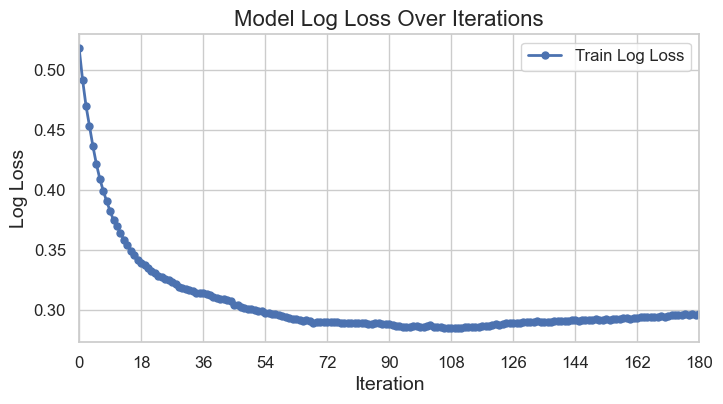

In [130]:
# Apply the seaborn style to make plots nicer
sns.set(style="whitegrid")

# Create the figure with a specific size
plt.figure(figsize=(8, 4))

# Assuming you have the training history from your XGBoost model run
# Replace 'xgb_history' with the actual variable name that stores the training history
xgb_history = xgb_model.evals_result()

# Accuracy plot
plt.subplot(1, 1, 1)
plt.plot(xgb_history['validation_0']['logloss'], label='Train Log Loss', linewidth=2, marker='o', markersize=5)

# Title and labels
plt.title('Model Log Loss Over Iterations', fontsize=16)
plt.ylabel('Log Loss', fontsize=14)
plt.xlabel('Iteration', fontsize=14)

# Legend
plt.legend(loc='upper right', fontsize=12)

# Set limits and ticks for readability
plt.xlim(0, len(xgb_history['validation_0']['logloss']) - 1)
plt.xticks(range(0, len(xgb_history['validation_0']['logloss']), max(len(xgb_history['validation_0']['logloss']) // 10, 1)), fontsize=12)
plt.yticks(fontsize=12);

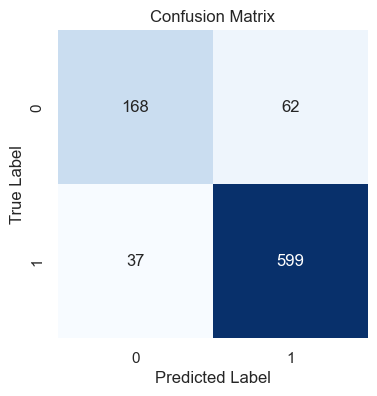

In [131]:
# Plotting the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

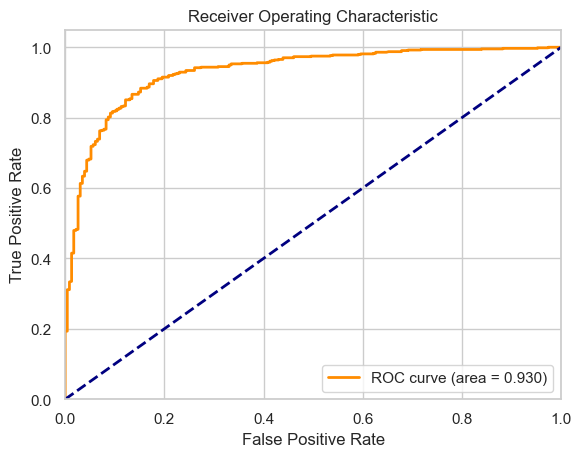

In [132]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

In [133]:
xgb_model.save_model(f"saved_models/XGBoost_model_Acc_{round(test_accuracy,3)}_F1_{round(f1,3)}_Roc_{round(roc_auc,3)}.bin")